# DSGRN Toggle-Switch Sheaf Tutorial
In this notebook, we build and analyze cellular sheaves for studying continuation of dynamics in the toggle-switch regulatory network.

In [1]:
import DSGRN
import DSGRN_utils

import matplotlib
import matplotlib.pyplot as plt

%run -i 'context.py'

# DSGRN Setup
First we specify the network. The toggle-switch regulatory network is a two-node network with two repressing edges.

In [2]:
net_spec = """
X1 :(~X2)
X2 :(~X1)
"""

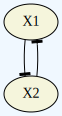

In [3]:
network = DSGRN.Network(net_spec)
DSGRN.DrawGraph(network)

The long-term behavior of this network is dependent on many parameters which govern the interactions between each node. DSGRN represents the various selections of these parameters in a "parameter graph". The nodes of this parameter graph represent subsets of parameter space over which the behavior of the network is the same. 

In [4]:
parameter_graph = DSGRN.ParameterGraph(network)
print('Parameter graph has size', parameter_graph.size())

Parameter graph has size 9


We can visualize the behavior of the network by plotting the state transition graphs at each parameter.

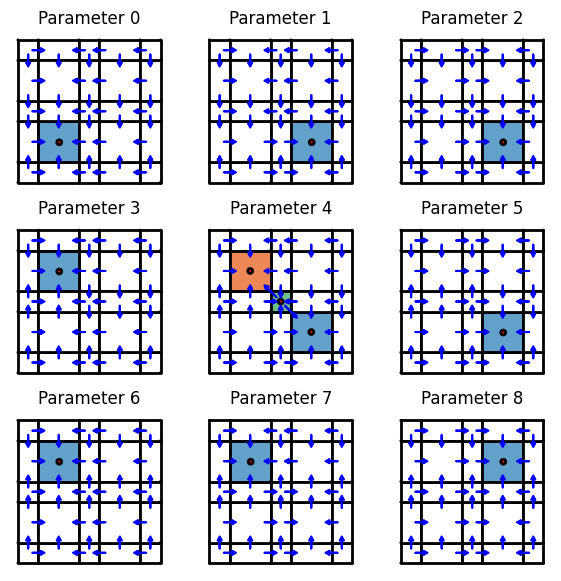

In [7]:
fig, axs = plt.subplots(3, 3,figsize=(7,7))
for i in range(9):                                                # For each of the nine parameters,
    parameter = parameter_graph.parameter(i)
    stg = DSGRN_utils.CubicalBlowupGraph(parameter, level=3) # build a state transition graph
    plot_stg(stg, ax=axs[i//3, i%3])                              # and plot it.
    axs[i//3, i%3].title.set_text("Parameter "+str(i))

For a general regulatory network, there are usually too many nodes in the parameter graph for us to plot all at once like this. The two axes in each of the state transition graphs correspond to the two nodes in the regulatory network. Each axis encodes various levels of activation for its corresponding node. 

At parameter 0 the attracting state is mutual deactivation, I.E. for any initial state you will always end up at deactivation of both nodes in the regulatory network. Conversely, at parameter 8 the repressing interactions are sufficiently weak that the attracting state is mutual activation. We can see that a single attracting state (monostability) encapsulates the dynamics at all parameter nodes except parameter 4. At parameter 4, there are two attracting states (bistability).

# Introduction to Continuation
Now we have the requisite data to discuss continuation. Looking at the various attracting states in the previous figure, it is clear the dynamics may also change when the parameter is varied. Continuation allows us to link these pictures together in a meaningful way. Let's take two adjacent parameter nodes in the parameter graph, say parameter 0 and parameter 1.

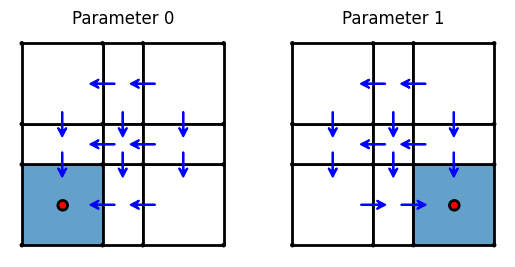

In [6]:
fig, axs = plt.subplots(1, 2)

parameter_0 = parameter_graph.parameter(0)
stg_0 = DSGRN_utils.RookRulesCubicalComplex(parameter_0, level=8)
plot_stg(stg_0, ax=axs[0])
axs[0].title.set_text("Parameter 0")

parameter_1 = parameter_graph.parameter(1)
stg_1 = DSGRN_utils.RookRulesCubicalComplex(parameter_1, level=8)
plot_stg(stg_1, ax=axs[1])
axs[1].title.set_text("Parameter 1")

The only difference between the two state transition graphs (I.E. the arrows from box to box) are the bottom two, which flip from pointing left at parameter 0 to pointing right at parameter 1. In turn, the attracting state moves from the bottom left corner to the bottom right corner. To establish continuation of dynamics between two adjacent parameter nodes, we consider the state transition graph given by superimposing the edges from each parameter node's state transition graph. The new graph is a coarse approximation of the state transition graphs for both parameters. 

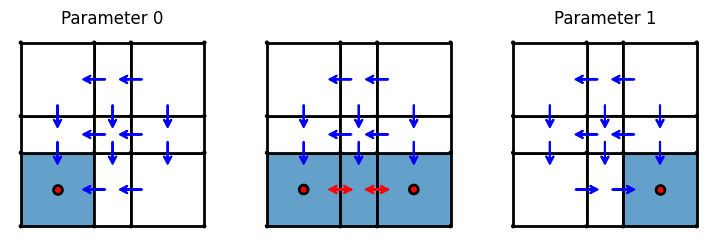

In [7]:
stg_01 = stg_union([stg_0, stg_1]) #Superimpose the two state transition graphs.

fig, axs = plt.subplots(1, 3, figsize=(9, 9))
plot_stg(stg_0, ax=axs[0])
axs[0].title.set_text("Parameter 0")
plot_stg(stg_01, ax=axs[1])
plot_stg(stg_1, ax=axs[2])
axs[2].title.set_text("Parameter 1")

So while the attracting states at parameter 0 and parameter 1 are different, they both fit inside the same Morse set for the coarsened model. In this way, we say that the attracting state at parameter 0 continues to that of parameter 1, and vice versa. We can perform this procedure between any two adjacent parameter nodes. Let's see what happens when we encounter a bifurcation moving from parameter 3 to parameter 4.

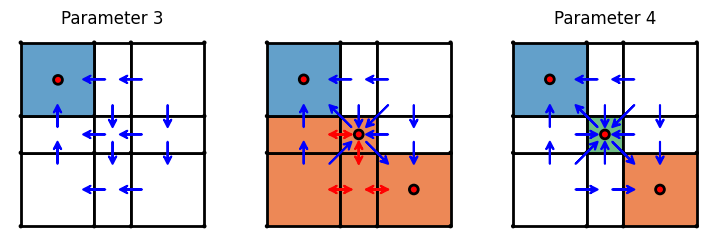

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(9,9))

parameter_3 = parameter_graph.parameter(3)
stg_3 = DSGRN_utils.RookRulesCubicalComplex(parameter_3, level=8)
plot_stg(stg_3, ax=axs[0])
axs[0].title.set_text("Parameter 3")

parameter_4 = parameter_graph.parameter(4)
stg_4 = DSGRN_utils.RookRulesCubicalComplex(parameter_4, level=8)
plot_stg(stg_4, ax=axs[2])
axs[2].title.set_text("Parameter 4")

stg_34 = stg_union([stg_3, stg_4])
plot_stg(stg_34, ax=axs[1])

The dynamics change from monostability to bistability when we move from parameter 3 to parameter 4. We have continuation of the attracting state in the top left corner for parameter 3 to the same attracting state in parameter 4 with no issues. However, the bottom right attracting state for parameter 4 does NOT continue across to parameter 3, since there are no features at parameter 3 with which it can get paired up. This is an example of a local phenomena failing to extend to a global phenomena.

Also, if we take the three Morse sets for parameter 4, they all fit inside the union of the two Morse sets for the coarsened model. Indeed, so does the attracting state at parameter 3. Therefore, not only does the attracting state at parameter 3 continue to a single attracting state at parameter 4, but also to the union of all three Morse sets at parameter 4.

This data can get extremely complicated very quickly as we consider more parameters and more interesting networks. We use a cellular sheaf defined over a parameter complex to manage all the information.

# Parameter Complexes & Sheaves
The first step is to come up with a structure which stores the state transition graphs at every parameter as well as the superimposed graphs given by two (or more) adjacent parameters. We call this the parameter complex. Mathematically, the parameter complex is designed to resemble a Cech Nerve complex. 

The elements of the parameter complex (called cells) correspond to state transition graphs via a Python dictionary. There is an ordering on the cells such that each pair of parameter nodes' state transition graphs lie above their superimposed graph. We invoke the full_parameter_complex function to build this object from a specified collection of indices.

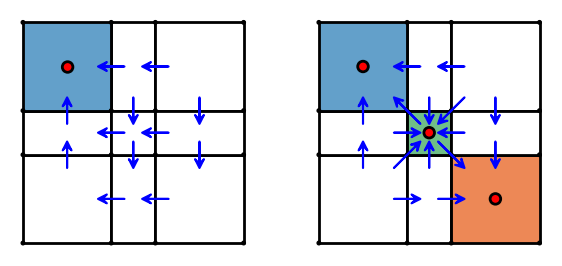

In [12]:
parameter_complex_34, stg_dict_34 = full_parameter_complex(parameter_graph, [3, 4], dim=1) #Notice we fix the dimension.
plot_stg_complex(parameter_complex_34, stg_dict_34, figsize=(7,7), tight=True)             #Display the top cells.
#(WARNING) Sometimes the plot_stg_complex method plots the state transition graphs in an order that's not intuitive.

The attractor sheaf attaches to every cell in the parameter complex the Z2 vector space generated by the Morse sets for its state transition graph. These vector spaces are called the stalks. So for example, at parameter 4 the stalk will be isomorphic to Z2^3 since there are three Morse sets. 

Suppose we have a Morse set for the state transition graph of a fixed parameter. For any state transition graph given by superimposing with that of the fixed parameter, the Morse set for the fixed parameter is contained in a unique Morse set for the superimposed graph. This defines a linear map between their stalks which sends a Morse set for the superimposed graph to the sum of Morse sets contained in it. These maps are called restriction maps.

By storing both the stalks at every cell and the restriction maps between the stalks, we have the structure of a (cellular) sheaf which systematically tracks continuation between the given parameters.

In [11]:
shf_34 = attractor_sheaf(parameter_complex_34, stg_dict_34)

print("Basis for stalk at parameter node 3:",shf_34.stalk(inequality_key(parameter_graph, 3) + (1,)))
print("Basis for stalk at parameter node 4:",shf_34.stalk(inequality_key(parameter_graph, 4) + (1,)))
print(shf_34.restr_dict)

Basis for stalk at parameter node 3: [frozenset({127})]
Basis for stalk at parameter node 4: [frozenset({127}), frozenset({117}), frozenset({122})]
{((frozenset({('p0', 'p1', 't0'), ('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 0), (frozenset({('p0', 'p1', 't0')}), frozenset({('p0', 't0', 'p1')}), 1)): GF([[1, 0]], order=2), ((frozenset({('p0', 'p1', 't0'), ('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 0), (frozenset({('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 1)): GF([[1, 0],
    [0, 1],
    [0, 1]], order=2), ((frozenset({('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 0), (frozenset({('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 1)): GF([[1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]], order=2), ((frozenset({('p0', 'p1', 't0')}), frozenset({('p0', 't0', 'p1')}), 0), (frozenset({('p0', 'p1', 't0')}), frozenset({('p0', 't0', 'p1')}), 1)): GF([[1]], order=2)}


To extract useful information about bifurcations, we employ sheaf cohomology. Sheaf cohomology groups are algebraic invariants which measure obstructions for local data (stalks) to extend to global data. The first cohomology group encodes the global sections, which are consistent choices of (sums of) Morse sets at every cell in the parameter complex. 

The sheaf_cohomology method returns a list of lists of generators for each cohomology group. Here we print the Betti numbers, which are the number of generators for each cohomology group.

In [94]:
shf_34_cohomology = sheaf_cohomology(shf_34)
print("Betti numbers:",[len(b) for b in shf_34_cohomology])

Betti numbers: [2, 0]


We can plot the global sections given by the first cohomology group with the plot_shf method.

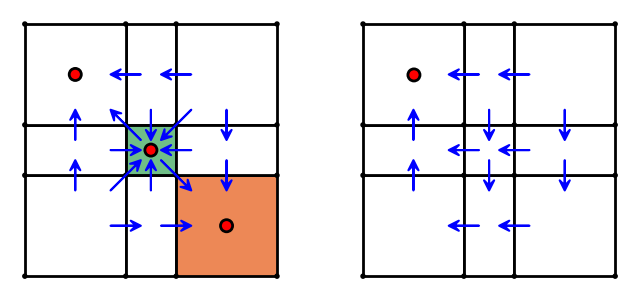

In [95]:
plot_shf(shf_34, stg_dict_34, section=shf_34_cohomology[0][0])

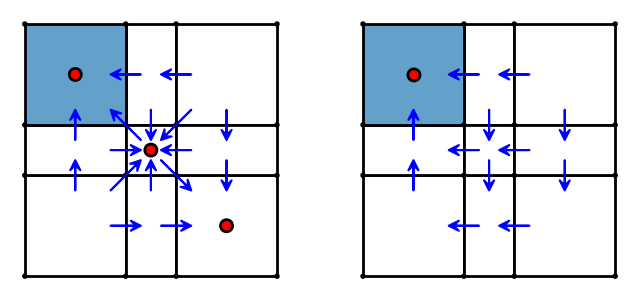

In [96]:
plot_shf(path_34_shf, stg_dict_34, section=shf_34_cohomology[0][1])

If we instead consider the sheaf formed between parameters 0 and 1, we only get one global section as opposed to two.

In [97]:
parameter_complex_01, stg_dict_01 = full_parameter_complex(parameter_graph, [0, 1], dim=1)
shf_01 = attractor_sheaf(parameter_complex_01, stg_dict_01)

shf_01_cohomology = sheaf_cohomology(shf_01)
print("Betti numbers:",[len(b) for b in shf_01_cohomology])

Betti numbers: [1, 0]


Let us examine some paths in parameter space that go through the bistability at parameter 4. First, we retrieve the adjacent nodes in the parameter graph.

In [71]:
adj = parameter_graph.adjacencies(4)
print(adj)

[1, 3, 5, 7]


Our "path" consists of the bistable node, and two of these adjacent nodes. Let's choose nodes 1 and 3. Along this path there are two saddle-node bifurcations, which together form hysteresis over the path.

In [83]:
path_134 = [1, 3, 4]

In [84]:
parameter_complex_134, stg_dict_134 = full_parameter_complex(parameter_graph, path_134, dim=1)
shf_134 = attractor_sheaf(parameter_complex_134, stg_dict_134)

There are three generators in the stalk corresponding to parameter 4 (bistability), and only one generator in the stalks corresponding to the adjacent (monostable) parameters.

In [85]:
print("Parameter node 4:",shf_134.stalk(inequality_key(parameter_graph, 4) + (1,)))
print("Parameter node 1:",shf_134.stalk(inequality_key(parameter_graph, 1) + (1,)))
print("Parameter node 3:",shf_134.stalk(inequality_key(parameter_graph, 3) + (1,)))

Parameter node 4: [frozenset({127}), frozenset({117}), frozenset({122})]
Parameter node 1: [frozenset({117})]
Parameter node 3: [frozenset({127})]


In [86]:
shf_134_cohomology = sheaf_cohomology(shf_134)
print("Betti numbers:",[len(b) for b in shf_134_cohomology])

Betti numbers: [1, 0]


Let's plot the global section.

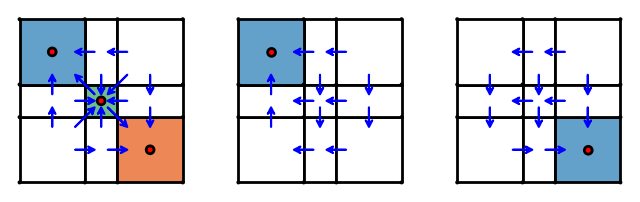

In [88]:
plot_shf(shf_134, stg_dict_134, section=shf_134_cohomology[0][0], columns=3)

If we instead consider the path going through parameter nodes 1 and 5, there are still two saddle-node bifurcations. However, this time they form an isola. This results in more global sections, and thus a higher first Betti number. In fact, since there is an attractor at parameter node 4 that is inaccesible from either adjacent parameter, we get a nontrivial second Betti number.

In [89]:
path_145 = [1, 5, 4]

parameter_complex_145, stg_dict_145 = full_parameter_complex(parameter_graph, path_145, 1)
shf_145 = attractor_sheaf(parameter_complex_145, stg_dict_145)
shf_145_cohomology = sheaf_cohomology(shf_145)

print("Parameter node 4:",shf_145.stalk(inequality_key(parameter_graph, 4) + (1,)))
print("Parameter node 1:",shf_145.stalk(inequality_key(parameter_graph, 1) + (1,)))
print("Parameter node 3:",shf_145.stalk(inequality_key(parameter_graph, 5) + (1,)))
print("")
print("Betti numbers:",[len(b) for b in shf_145_cohomology])

Parameter node 4: [frozenset({127}), frozenset({117}), frozenset({122})]
Parameter node 1: [frozenset({117})]
Parameter node 3: [frozenset({117})]

Betti numbers: [2, 1]


Let's plot these two global sections.

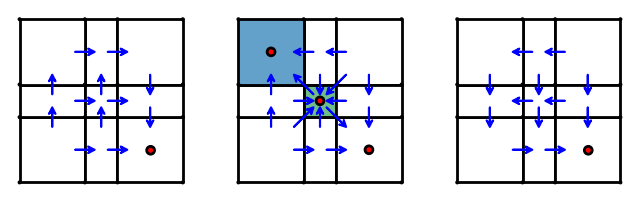

In [90]:
plot_shf(shf_145, stg_dict_145, shf_145_cohomology[0][0], columns=3)

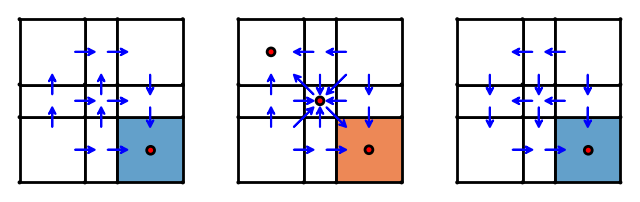

In [91]:
plot_shf(shf_145, stg_dict_145, shf_145_cohomology[0][1], columns=3)

# Continuation through loops

We can study continuation on more complicated parameter complexes. Let's compare some loops in parameter space. The following loops our first path through parameter node 0, the one experiencing hysteresis.

In [23]:
loop_0134 = [0, 1, 3, 4]

parameter_complex_0134, stg_dict_0134 = full_parameter_complex(parameter_graph, loop_0134, dim=1) #Still one dimensional.
shf_0134 = attractor_sheaf(parameter_complex_0134, stg_dict_0134)

Let's plot the stalks of this sheaf. This time we'll include the cells corresponding to the superimposed state transition graphs, which will be plotted inbetween the corners.

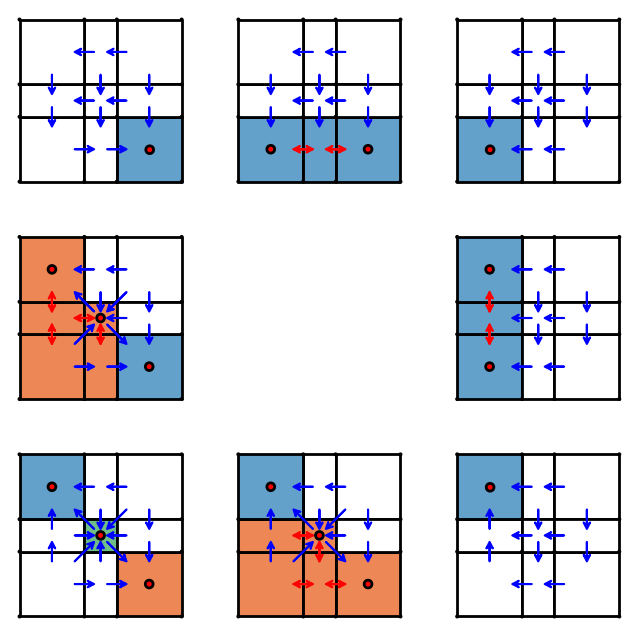

In [24]:
plot_shf_loop(shf_0134, stg_dict_0134, top_only=False)

In [26]:
shf_0134_cohomology = sheaf_cohomology(shf_0134)
print("Betti numbers:",[len(b) for b in shf_0134_cohomology])
print(shf_0134.restr_dict)

Betti numbers: [1, 1]
{((frozenset({('p0', 'p1', 't0'), ('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 0), (frozenset({('p0', 'p1', 't0')}), frozenset({('p0', 't0', 'p1')}), 1)): GF([[1, 0]], order=2), ((frozenset({('p0', 'p1', 't0'), ('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 0), (frozenset({('p0', 't0', 'p1')}), frozenset({('p0', 't0', 'p1')}), 1)): GF([[1, 0],
    [0, 1],
    [0, 1]], order=2), ((frozenset({('p0', 'p1', 't0'), ('p0', 't0', 'p1')}), frozenset({('p0', 'p1', 't0')}), 0), (frozenset({('p0', 't0', 'p1')}), frozenset({('p0', 'p1', 't0')}), 1)): GF([[1]], order=2), ((frozenset({('p0', 'p1', 't0'), ('p0', 't0', 'p1')}), frozenset({('p0', 'p1', 't0')}), 0), (frozenset({('p0', 'p1', 't0')}), frozenset({('p0', 'p1', 't0')}), 1)): GF([[1]], order=2), ((frozenset({('p0', 'p1', 't0')}), frozenset({('p0', 'p1', 't0'), ('p0', 't0', 'p1')}), 0), (frozenset({('p0', 'p1', 't0')}), frozenset({('p0', 't0', 'p1')}), 1)): GF([[1]], order=2), ((frozenset({('p0', 'p1', '

The sheaf cohomology here is what one would expect from a constant sheaf on a loop: one generator in each dimension. However, there are three generators at parameter node 4, which fail to continue globally due to the hysteresis. This data suggests the existence of a cusp bifurcation between these four nodes. The story is different when we loop through an isola.

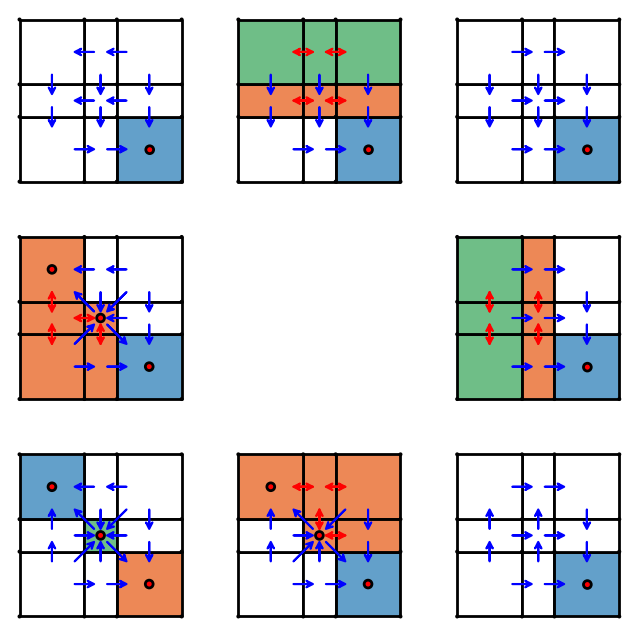

In [21]:
loop_1245 = [1, 2, 4, 5]

parameter_complex_1245, stg_dict_1245 = full_parameter_complex(parameter_graph, loop_1245, 1)
shf_1245 = attractor_sheaf(parameter_complex_1245, stg_dict_1245)

plot_shf_loop(shf_1245, stg_dict_1245, top_only=False)

In [22]:
shf_1245_cohomology = sheaf_cohomology(shf_1245)
print("Betti numbers:",[len(b) for b in shf_1245_cohomology])

Betti numbers: [6, 2]


Not only do we have more global sections, including the continuation of the bottom right attracting state, but we also have a higher second Betti number. This is due to the top left attracting state at parameter 4 being inaccessible by continuation from either parameter 5 or parameter 1. 